<a href="https://colab.research.google.com/github/ashraj98/rbf-sin-approx/blob/main/Lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2

### Ashwin Rajgopal

Start off by importing numpy for matrix math, random for random ordering of samples and pyplot for plotting results.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import random

#### Creating the samples

X variables can be generated by using `np.random.rand` to generate a array of random numbers between 0 and 1, which is what is required. The same can be done to generate the noise, but then it needs to be divided by 5 and subtracted by .1 to fit the interval [-0.1, 0.1]. The expected values can then by generated applying the function to the inputs and adding the noise.

For plotting the original function that will be approximated by the RBF network, `linspace` can be used to generate equally spaced inputs to make a smooth plot of the function.

In [9]:
X = np.random.rand(1, 75).flatten()
noise = np.random.rand(1, 75).flatten() / 5 - 0.1
D = 0.5 + 0.4 * np.sin(2 * np.pi * X) + noise

func_X = np.linspace(0, 1, 100)
func_Y = 0.5 + 0.4 * np.sin(2 * np.pi * func_X)

#### K-means algorithm

This function finds the centers and variances given uncategorized inputs and number of clusters. It also takes in a flag to determined whether to output an averaged variance for all clusters or use specialized variances for each cluster.

The algorithm begins by choosing random points from the inputs as the center of the clusters, so that every cluster will have at least point assigned to it. Then the algorithm repetitively assigns points to each cluster using Euclidean distance and averages the assigned points for each cluster to find the new centers. The new centers are compared with the old centers, and if they are the same, the algorithm is stopped.

Then using the last assignment of the points, the variance for each cluster is calculated. If a cluster does not have more than one point assigned to it, it is skipped.

If `use_same_width=True`, then an normalized variance is used for all clusters. The maximum distance is used by using an outer subtraction between the centers array and itself, and then it is divided by `sqrt(2 * # of clusters)`.

If `use_same_width=False`, then for all clusters that had only one point assigned to it, the average of all the other variances is used as the variance for these clusters.

In [10]:
def kmeans(clusters=2, X=X, use_same_width=False):
  centers = np.random.choice(X, clusters, replace=False)
  diff = 1
  while diff != 0:
    assigned = [[] for i in range(clusters)]
    for x in X:
      assigned_center = np.argmin(np.abs(centers - x))
      assigned[assigned_center].append(x.item())
    new_centers = np.array([np.average(points) for points in assigned])
    diff = np.sum(np.abs(new_centers - centers))
    centers = new_centers
  variances = []
  no_var = []
  for i in range(clusters):
    if len(assigned[i]) < 2:
      no_var.append(i)
    else:
      variances.append(np.var(assigned[i]))
  if use_same_width:
    d_max = np.max(np.abs(np.subtract.outer(centers, centers)))
    avg_var =  d_max / np.sqrt(2 * clusters)
    variances = [avg_var for i in range(clusters)]
  else:
    if len(no_var) > 0:
      avg_var = np.average(variances)
      for i in no_var:
        variances.insert(i, avg_var)
  return (centers, np.array(variances))

The function below defines the gaussian function. Given the centers and variances for all clusters, it calculates the output for all gaussians at once for a single input.

In [11]:
def gaussian(centers, variances, x):
  return np.exp((-1 / (2 * variances)) * ((centers - x) ** 2))

#### Training the RBF Network

For each gaussian, a random weight is generated in the interval [-1, 1]. The same happens for a bias term as well.

Then, for the number of epochs specified, the algorithm calculates the gaussian outputs for each input, and then takes the weighted sum and adds the bias to get the output of the network. Then the LMS algorithm is applied.

Afterwards, the `linspace`d inputs are used to generate the outputs, which allows for plotting the approximating function. Then both the approximated function (red) and the approximating function (blue) are plot, as well as the training data with the noise.

In [12]:
def train(centers, variances, lr, epochs=100):
  num_centers = len(centers)
  W = np.random.rand(1, num_centers) * 2 - 1
  b = np.random.rand(1, 1) * 2 - 1
  order = list(range(len(X)))
  for i in range(epochs):
    random.shuffle(order)
    for j in order:
      x = X[j]
      d = D[j]
      G = gaussian(centers, variances, x)
      y = W.dot(G) + b
      e = d - y
      W += lr * e * G.reshape(1, num_centers)
      b += lr * e
  est_Y = []
  for x in func_X:
    G = gaussian(centers, variances, x)
    y = W.dot(G) + b
    est_Y.append(y.item())
  est_Y = np.array(est_Y)
  fig = plt.figure()
  ax = plt.axes()
  ax.scatter(X, D, label='Sampled')
  ax.plot(func_X, est_Y, '-b', label='Approximate')
  ax.plot(func_X, func_Y, '-r', label='Original')
  plt.title(f'Bases = ${num_centers}, Learning Rate = ${lr}')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.legend(loc="upper right")

The learning rates and number of bases that needed to be tested are defined, and then K-means is run for each combination of base and learning rate. The output of the K-means is used as the input for the RBF training algorithm, and the results are plotted.

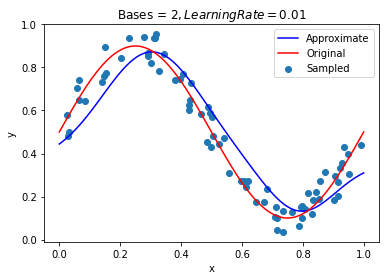

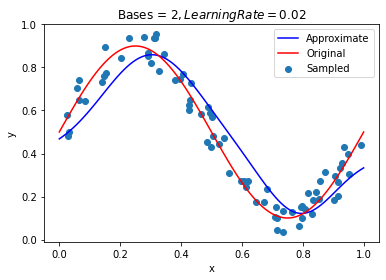

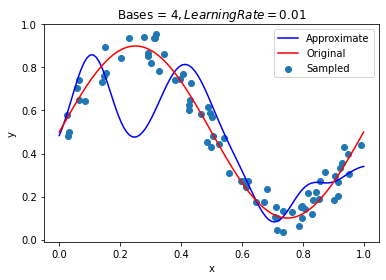

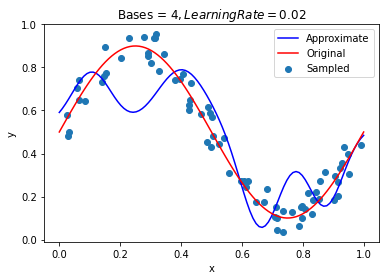

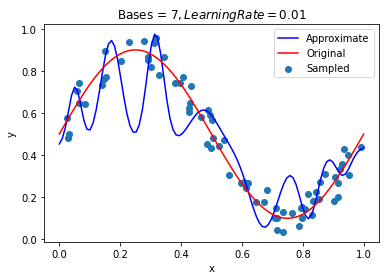

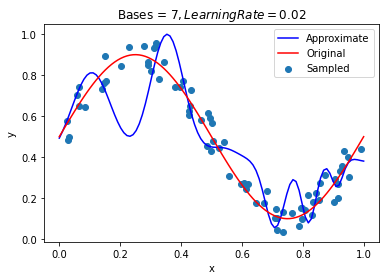

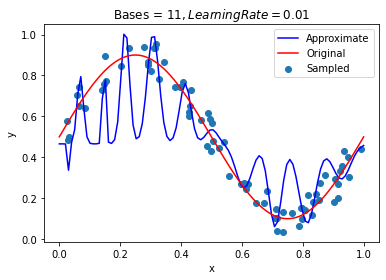

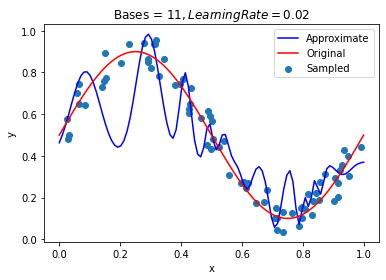

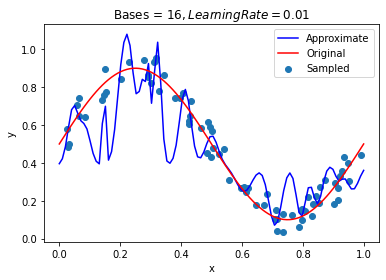

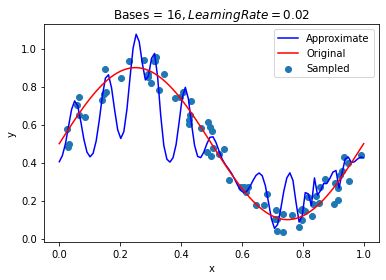

In [13]:
bases = [2, 4, 7, 11, 16]
learning_rates = [.01, .02]
for base in bases:
  for lr in learning_rates:
    centers, variances = kmeans(base, X)
    train(centers=centers, variances=variances, lr=lr)

The best function approximates seem to be with 2 bases. As soon as the bases are increased to 4, overfitting starts to occur, with 16 bases having extreme overfitting.

Increasing the learning rate seems to decrease the training error but in some cases increases the overfitting of the data.

Run the same combinations or number of bases and learning rate again, but this time using the same Gaussian width for all bases.

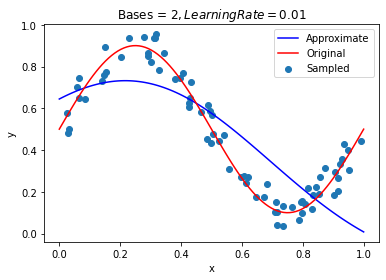

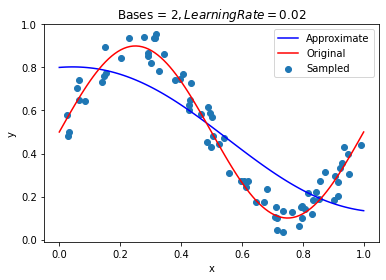

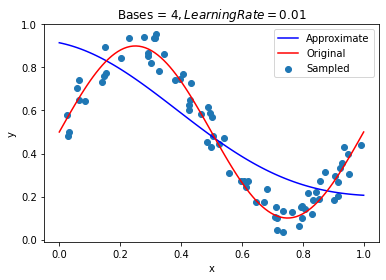

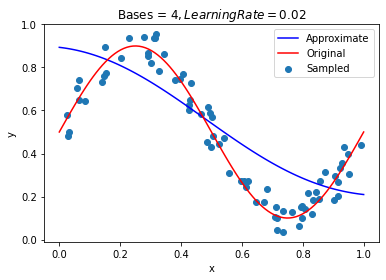

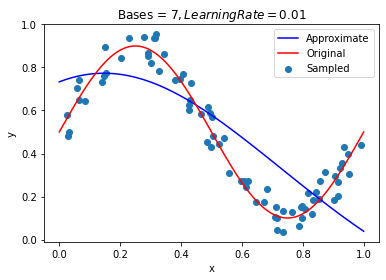

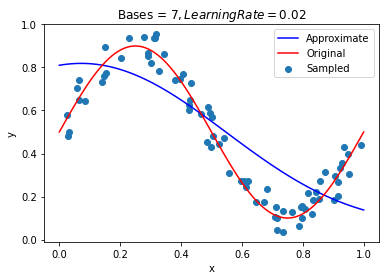

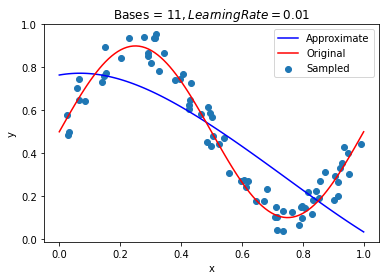

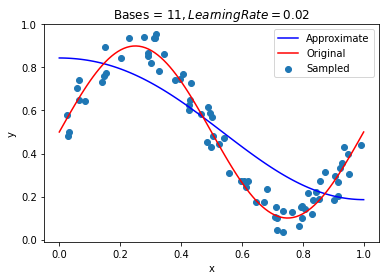

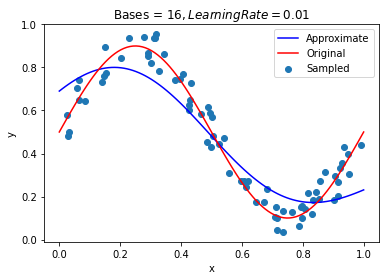

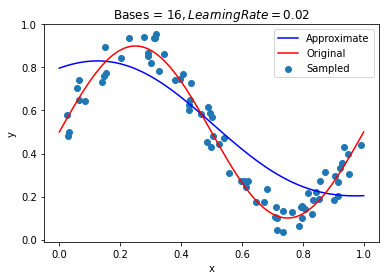

In [14]:
for base in bases:
  for lr in learning_rates:
    centers, variances = kmeans(base, X, use_same_width=True)
    train(centers=centers, variances=variances, lr=lr, epochs=100)

Using the same width for each base seems to drastically decrease overfitting. Even with 16 bases, the approximating function is very smooth. However, after 100 epochs, the training error is still very high, and the original function is not well approximated.

After running the training with significantly more epochs (10,000 to 100,000), the function becomes well approximated for large number of bases. But for smaller number of bases like 2, the approximating function is still not close to the approximated function, whereas when using different Gaussian widths, 2 bases was the best approximator of the original function.

So, using the same widths, the training takes significantly longer and requires many bases to be used to approximate the original function well.